In [1]:
using DataFrames, CSV, DelimitedFiles, Plots, FFTW
include("/home/kirk/Documents/research/CHANDRATest/DJM.jl")

Main.DJM

In [2]:
pows12=CSV.read("cxc.fftinfo.all12")

,obsid,srcnum,startdate,exptime,ra,dec,freq,power
,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64
1,1026,26,51833.8,6458.48,19.9382,-73.4501,0.00123975,13.2664
2,1028,105,51856.5,6324.74,19.038,-73.414,0.000316292,13.824
3,1028,113,51856.5,6324.74,18.9547,-73.4035,0.00110873,31.303
4,1028,113,51856.5,6324.74,18.9547,-73.4035,0.00126712,12.1519
5,1028,38,51856.5,6324.74,19.8812,-73.5169,0.00110816,21.5887
6,1028,88,51856.5,6324.74,19.1853,-73.4323,0.000316454,12.6433
7,1029,13,52024.6,6120.26,19.6143,-73.4658,0.00115807,56.0898
8,1030,14,52025.6,6152.72,19.6181,-73.4675,0.00114639,74.6027
9,1030,14,52025.6,6152.72,19.6181,-73.4675,0.00212901,18.2923


In [4]:
function pdot(f) #change in period due to accretion, serious estimating involved
    Pdot2 = -2  #seconds/year
    Pdot1 = -5
    P1 = 0
    P2 = 3
    plog=log10(1/f)

    dpdot = (Pdot2 - Pdot1)/(P2-P1)
    logpdot = Pdot1 + (plog-P1)*dpdot
    return(10^logpdot)
end

pdot (generic function with 1 method)

In [5]:
using Formatting
#Note: running this function for pows8 took ~2.5min on my laptop
function createPowMatrix(powList)
    n=ceil(maximum(powList.power[:]))
    df=0.0001
    nk=ceil(maximum(powList.freq[:])/df)
    powMatrix=zeros(101,101,Int(nk)+1) #any power greater than 100 will go in 101,nk for freq z direction, +1 because 1 is for normal matrix
    justPow=powList.power[:]
    errorCount=0
    counter=0
    for i in 1:length(justPow)
        print(format(i/length(justPow)*100,precision=2),"% complete\r") #output % tracker
        if ceil(powList.power[i])>100
            currentRow=101 #power is too big
        else
            currentRow=ceil(powList.power[i]) #row index for use later
        end
        
        for j in (i+1):length(justPow) #i+1 accounts for indistinguishability
            counter+=1
            if ceil(powList.power[j])>100
                currentCol=101 #other power too big
            else
               currentCol=ceil(powList.power[j]) #column index for use later
            end
            try #need to use try statement because gcdist breaks sometimes?
                rdist = DJM.gcdist(powList.ra[j],powList.dec[j],powList.ra[i],powList.dec[i])
                if (rdist*60.0 > 0.01666) #not in the same place
                    powMatrix[Int(currentRow),Int(currentCol),1]+=1 #found a pair, doesn't account for overcounting (indistinguishability)
                    #stuff below for freq z part of matrix
                    fAvg=(powList.freq[i]+powList.freq[j])/2
                    fAvgDot=1/pdot(fAvg)
                    dt=abs(powList.exptime[i]-powList.exptime[j]) #is exptime the timestamp?
                    fRangeMax=fAvgDot*dt
                    fRangeMin=fAvgDot*(-dt)
                        if fAvg>=fRangeMin && fAvg<=fRangeMax
                            kInd=ceil(fAvg/df)                                
                            #println(kInd," successfully appended to k index") note: it does work!
                            powMatrix[Int(currentRow),Int(currentCol),Int(kInd+1)]+=1 #kInd+1 because 1 is base matrix
                        end
                end
            catch
                errorCount+=1 #this error is because it tries to take acos of #>1 (I think) in gcdist
                              #maybe because of rounding errors?
            end
        end
    end
    println(errorCount," total errors accumulated")
    println(errorCount/counter*100,"% error")
    return powMatrix
end

test=createPowMatrix(pows12)

3094 total errors accumulated
0.17953967281302805% error


101×101×1545 Array{Float64,3}:
[:, :, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  …    0.0    0.0    0.0    0.0      0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0       0.0    0.0    0.0    0.0      0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0       0.0    0.0    0.0    0.0      0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0       0.0    0.0    0.0    0.0      0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0       0.0    0.0    0.0    0.0      0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  …    0.0    0.0    0.0    0.0      0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0       0.0    0.0    0.0    0.0      0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0       0.0    0.0    0.0    0.0      0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0       0.0    0.0    0.0    0.0      0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0       0.0    0.0    0.0    0.0      0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  …    0.0    0.0    0.0    0.0      0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0       0.0    0.0    0.0    0.0      0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     204.0  391.0  408.

In [32]:
sums=zeros(length(test[1,1,2:end]))
for i in 1:length(test[1,1,2:end])
    sums[i]+=sum(test[:,:,i+1]) #i+1 becaus normal matrix is in 1st slice
end
    

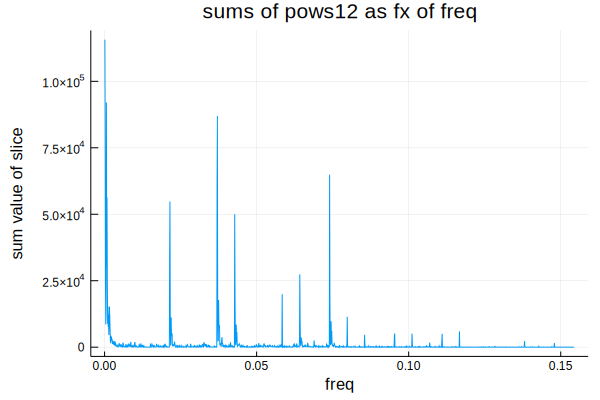

In [66]:
using Plots
df=0.0001
fbins=ceil(maximum(pows12.freq[:])/df)
frange=zeros(Int(fbins))
for i in 1:length(frange)
    frange[i]=i*df
end

plot(frange,sums,title="sums of pows12 as fx of freq",xlabel="freq",ylabel="sum value of slice",label="")

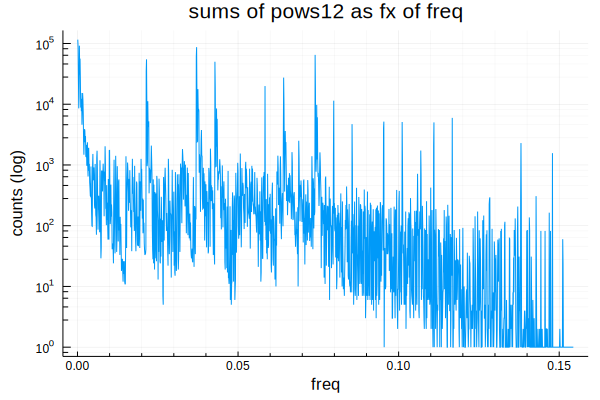

In [70]:
sums4log=zeros(length(sums))
for i in 1:length(sums4log)
    if sums[i]==0
        sums4log[i]=1
    else
        sums4log[i]=sums[i]
    end
end
plot(frange,sums4log,yaxis=:log,title="sums of pows12 as fx of freq",xlabel="freq",ylabel="counts (log)",label="",minorticks=true,minorgrid=true)

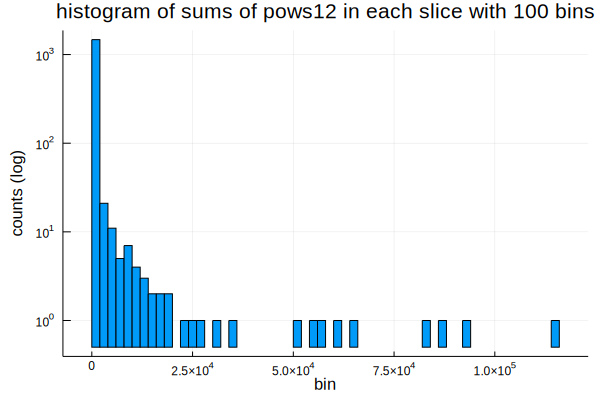

In [68]:
histogram(sums,bins=100,yaxis=:log,title="histogram of sums of pows12 in each slice with 100 bins",xlabel="bin",ylabel="counts (log)",label="")

In [54]:
function genFreqSums(powMatrix)
    sums=zeros(length(powMatrix[1,1,2:end]))
    for i in 1:length(powMatrix[1,1,2:end])
        sums[i]+=sum(powMatrix[:,:,i+1]) #i+1 becaus normal matrix is in 1st slice
    end
    return sums
end
function sumsLog(sums)
    sums4log=zeros(length(sums))
    for i in 1:length(sums4log)
        if sums[i]==0
            sums4log[i]=1
        else
            sums4log[i]=sums[i]
        end
    end
    return sums4log
end
function genFRange(df,powList)
    fbins=ceil(maximum(powList.freq[:])/df)
    frange=zeros(Int(fbins))
    for i in 1:length(frange)
        frange[i]=i*df
    end
    return frange
end


genFRange (generic function with 1 method)

In [53]:
pows8=CSV.read("cxc.fftinfo.all8")
pows8Matrix=createPowMatrix(pows8)
sums8=genFreqSums(pows8Matrix)
sums8Log=sumsLog(sums8)

13475 total errors accumulated
0.021276802356348625% error


1546-element Array{Float64,1}:
 208225.0
 198709.0
  98275.0
  54667.0
  57434.0
 226288.0
 111350.0
 152671.0
  87963.0
  51038.0
  72288.0
  46040.0
  60017.0
      ⋮  
    610.0
    737.0
    849.0
    665.0
    520.0
    196.0
    172.0
    184.0
    157.0
     90.0
     25.0
      1.0

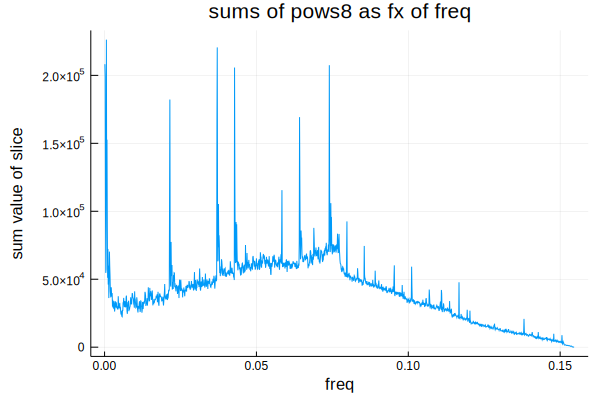

In [63]:
fRange8=genFRange(0.0001,pows8)
plot(fRange8,sums8,title="sums of pows8 as fx of freq",xlabel="freq",ylabel="sum value of slice",label="")

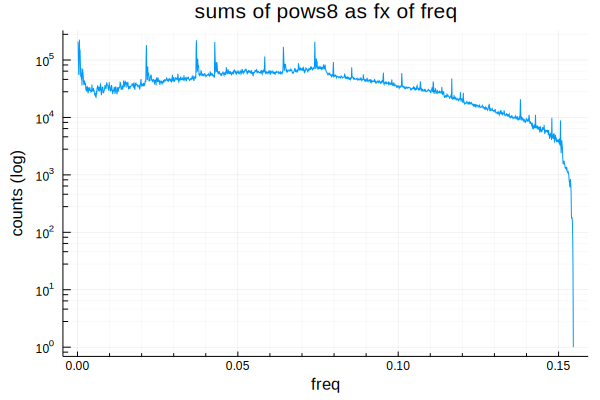

In [69]:
plot(fRange8,sums8Log,yaxis=:log,title="sums of pows8 as fx of freq",xlabel="freq",ylabel="counts (log)",label="",minorticks=true,minorgrid=true)

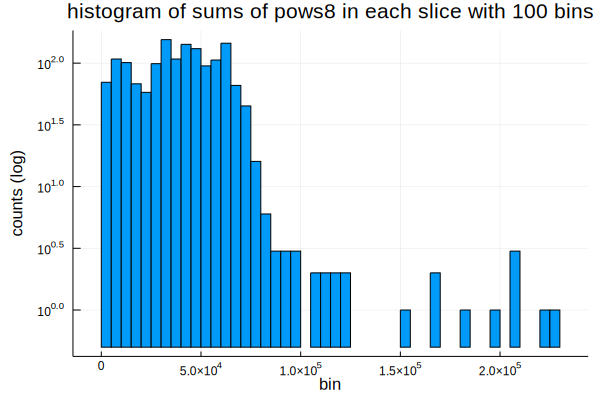

In [65]:
histogram(sums8,bins=100,yaxis=:log,title="histogram of sums of pows8 in each slice with 100 bins",xlabel="bin",ylabel="counts (log)",label="")